# Outlier Detection (PyOD library)

### Introduction

As described in documentation, PyOD is a Python Toolbox for Scalable Outlier Detection (Anomaly Detection). PyOD includes more than 30 detection algorithms, from classical LOF (SIGMOD 2000) to the latest COPOD (ICDM 2020). 

To know more about it, visit https://pyod.readthedocs.io/en/latest/

For this notebook, we will see how knn algorithm works for Outlier Detection using a synthetic dataset.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties

In [2]:
from pyod.models.knn import KNN

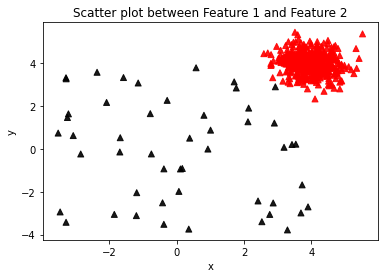

In [3]:
#Importing library to generate synthetic data with outliers and also to separate outliers and inliers
from pyod.utils.data import generate_data,get_outliers_inliers

# Let's say we want 10% of the generated data to be outlier
outlier_size = 0.1 

# Defining the parameters for generating data
train_size = 500
test_size = 100
features = 2

# Generating data
X_train, X_test, y_train, y_test = generate_data(n_train=train_size, n_test=test_size, n_features= features, contamination=outlier_size,behaviour='new',random_state=43)

X_train_pd = pd.DataFrame(X_train) #Converting just for plotting

# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.9,marker='^',cmap='flag')
plt.title('Scatter plot between Feature 1 and Feature 2')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## In the above plot, it can be clearly seen that the purple crosses have formed a cluster and yellow ones are scattered.

In [4]:
# Train kNN detector
from pyod.models.knn import KNN
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
# To see the predictions of the training data
y_train_scores = clf.decision_scores_

In [5]:
# Now we apply it to test data
y_test_pred = clf.predict(X_test) # 0 is for not outlier and 1 is for outlier.
# Since, we generated a test size of 100, we should have 10 outliers and 90 not outliers
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))

{0: 90, 1: 10}

In [6]:
y_test_scores = clf.decision_function(X_test)
print(y_test_scores)

[0.32112057 0.07550744 0.08157521 0.08105868 0.15651941 0.08594175
 0.09082986 0.25611493 0.0882177  0.10026444 0.07171049 0.09626428
 0.12935318 0.07855414 0.09618301 0.08519274 0.18552847 0.08681479
 0.06428241 0.07036384 0.09449584 0.07751236 0.09066827 0.05585442
 0.50772268 0.32991195 0.17149997 0.25538265 0.25417752 0.20550725
 0.10345733 0.06163438 0.0972531  0.51846747 0.16118101 0.14075726
 0.12767723 0.10595214 0.05134455 0.07247349 0.09412659 0.09207206
 0.05417632 0.14540294 0.0733352  0.05584352 0.09080601 0.33802385
 0.08671098 0.1428903  0.08998602 0.07884532 0.21883131 0.07795742
 0.19783848 0.09464795 0.25183794 0.07594047 0.05594977 0.1190418
 0.09035058 0.10117402 0.15325195 0.11337551 0.10450767 0.09349699
 0.09165021 0.08136575 0.11551062 0.11259703 0.12991518 0.11832771
 0.15315889 0.05407252 0.08686296 0.16972077 0.08542368 0.09696699
 0.28422542 0.06440607 0.07034449 0.07278068 0.08275881 0.13715184
 0.13345305 0.04632306 0.1972681  0.06530809 0.11299542 0.11557

### The above values are generally called anomaly score. 

### As we know, In k-NN models, we use the Euclidean distance to measure the distance. 

### An outlier is a point that is distant from neighboring points, so the outlier score is defined by the distance value. This point is explained in the author’s source code: “For an observation, its distance to its kth nearest neighbor could be viewed as the outlying score. It could be viewed as a way to measure the density.” 

Reference: https://towardsdatascience.com/anomaly-detection-with-pyod-b523fc47db9

### What we mean by above discussion is that beyond a specific threshold we classify observations as outliers based on these anomaly scores. Let's plot these scores on a histogram and see what it tells.

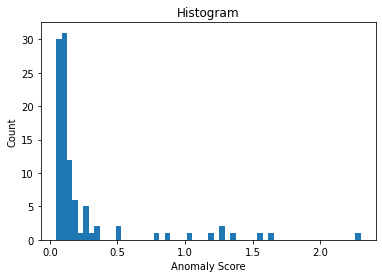

In [7]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')
plt.title("Histogram")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.show()

### The higher the anomaly score, more abnormal is the observation. From above we can say that our threshold might be 0.5 and above. This is because most observation falls to the left of 0.5 and very few are above it.

In [8]:
# Let's see how many '0's and '1's.
df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<0.5, 0, 1)
df_test['cluster'].value_counts()

0    88
1    12
Name: cluster, dtype: int64

In [9]:
df_test.groupby('cluster').mean()

,0,1,score
cluster,,,
0,4.049749,3.973604,0.119622
1,0.777974,0.705299,1.192762


### As we can see the average anomaly score in Cluster 1 is much higher than that of Cluster 0. The summary statistics also show dramatic differences between the two clusters. We thus believe the data points in Cluster 1 could be anomalous (or outliers) and should be studied further.

In [10]:
x_outliers, x_inliers = get_outliers_inliers(X_train,y_train)

In [11]:
from scipy import stats
#set the figure size
plt.figure(figsize=(20, 6))
xx , yy = np.meshgrid(np.linspace(-20, 10, 100), np.linspace(-20, 10, 100))
n_outliers = len(x_outliers)

# predict raw anomaly score
scores_pred = clf.decision_function(X_train)*-1

# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X_train)

# no of errors in prediction
n_errors = (y_pred != y_train).sum()
print('No of Errors : ',clf_name, n_errors)


# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 *outlier_size)

# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

subplot = plt.subplot(1, 2, i + 1)

# fill blue colormap from minimum anomaly score to threshold value
subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.magma)

    # draw red contour line where anomaly score is equal to threshold
a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='green')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='lightgreen')

    # scatter plot of inliers with white dots
b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
subplot.axis('tight')

subplot.legend(
    [a.collections[0], b, c],
    ['Learned Decision Function', 'Observations/Inliers', 'True Outliers'],
    prop=FontProperties(size=12),
    loc='lower right')

subplot.set_title(clf_name)
subplot.set_xlim((-10, 10))
subplot.set_ylim((-10, 10))
plt.show() 

No of Errors :  KNN 2


NameError: name 'i' is not defined

### From the above diagram, outliers and other observation (inliers for anomaly detection) can be easily seen.

The PyOD library has many algorithms divided into sections like linear algorithms, combination algorithms, deep learning and many more. So, visit the original documentation and see what all is included. 